## Installing / Importing Packages 

The following packages are required for the notebook to work.

In [1]:
#Importing the required modules
import os
import csv
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Inserting Information to CSV File Column

This function takes three input parameters:

- **csvFile** - The location of the filename to retrieve information from.
- **directoryName** - The information to be inserted. 
- **columnIndex** - The column of the file to insert through.

The file is first opened and all values are rewritted with the directoryName parameter concatenated with them. The file is then saved.

In [2]:
#Defining a function to append the directory name to the column
def appendDirectoryToColumn(csvFile, directoryName, columnIndex):
    #Reading the CSV file and storing its contents
    with open(csvFile, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)

    #Appending the directory name to each value in the specified column
    for row in rows:
        row[columnIndex] = directoryName + row[columnIndex]

    #Writing the modified data back to the CSV file
    with open(csvFile, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)

#Appending the directory name to the first column of the CSV files
appendDirectoryToColumn("./Object_Detection_Dataset/CSV/Train/labels.csv", "./Object_Detection_Dataset/CSV/Train/images/", 0)
appendDirectoryToColumn("./Object_Detection_Dataset/CSV/Val/labels.csv", "./Object_Detection_Dataset/CSV/Val/images/", 0)
appendDirectoryToColumn("./Object_Detection_Dataset/CSV/Test/labels.csv", "./Object_Detection_Dataset/CSV/Test/images/", 0)

## Getting Centroids and Image Sizes from CSV Files

This function takes two input parameters:

- **annotation_files** - A list containing the CSV filename locations.
- **return_sizes** - A boolean variable to denote whether the image sizes are to be returned or not.

This function loops through the three CSV files and saves each emoji's centre point coordinate as well as the respective image size.

In [3]:
#Defining a function to read the annotations from the CSV file
def read_csv_annotations(annotation_files, return_sizes=False):
    #Initialising the lists to store the centroids and image sizes
    centroids = []
    image_sizes = []
    #Iterating through the CSV files
    for annotations_file in annotation_files:
        #Reading the CSV file and storing its contents
        with open(annotations_file, 'r') as file:
            reader = csv.reader(file)
            #Iterating through the rows of the CSV file
            for row in reader:
                #Extracting the required information from the row
                image_path = row[0]
                x1 = float(row[1])
                y1 = float(row[2])
                x2 = float(row[3])
                y2 = float(row[4])
                #Calculating the centroid of the bounding box
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2
                centroid = (x_center, y_center)
                centroids.append(centroid)
                #Calculating the size of the image
                if return_sizes:
                    image = cv2.imread(image_path)
                    if image is not None:
                        height, width, _ = image.shape
                        image_sizes.append((width, height))
                    else:
                        print(f"Warning: Image {image_path} not found.")
    #Converting the centroids and image sizes to numpy arrays
    centroids = np.array(centroids)
    image_sizes = np.array(image_sizes)
    #Returning the centroids and image sizes
    if return_sizes:
        return centroids, image_sizes
    else:
        return centroids

## Calculating Centre Bias

This function takes three input parameters:

- **centroids** - A list containing the centre coordinate of each emoji.
- **image_sizes** - A list containing the image sizes corresponding to each centroid.
- **heatmap_size** - The size of the heatmap to be displayed.

This function creates a heatmap by first scaling the centroid in proportion to its original image size, and places the newly calculated coordinate within the heatmap grid. The result is then normalised by the total number of annotations.

In [4]:
#Defining a function to calculate the center bias
def calculate_center_bias(centroids, image_sizes, heatmap_size=(512, 512)):
    #Calculating the number of annotations
    num_annotations = len(centroids)
    #Initialising the center bias
    center_bias = np.zeros(heatmap_size)
    #Iterating through the centroids
    for i, centroid in enumerate(centroids):
        #Extracting the x and y coordinates of the centroid
        x, y = centroid
        #Scaling the x-coordinate based on the ratio of the heatmap width to the image's actual width
        x *= heatmap_size[0] / image_sizes[i][0]
        #Scaling the y-coordinate based on the ratio of the heatmap height to the image's actual height
        y *= heatmap_size[1] / image_sizes[i][1]
        #Rounding the coordinates to the nearest integer and incrementing the corresponding cell in the heatmap
        x = int(x)
        y = int(y)
        center_bias[y, x] += 1

    #Normalising the center bias
    center_bias /= num_annotations  

    return center_bias

## Visualising Centre Bias Graph

This function takes one input parameter:

- **center_bias** - A matrix storing the centre bias information.

This function depicts a heatmap by utilising a gaussian filter to create a blurring effect with a colour bar to depict the frequency of the centroids.

In [5]:
#Defining a function to visualise the center bias
def visualize_center_bias(center_bias):
    #Blurring the center bias heatmap
    blurred_center_bias = gaussian_filter(center_bias, sigma=5)
    #Plotting the center bias heatmap
    plt.imshow(blurred_center_bias, cmap='hot', interpolation='nearest')
    plt.title('Center Bias Heatmap')
    #Creating custom ticks and labels for the colorbar
    num_ticks = 8
    tick_values = np.linspace(0, 1.75, num=num_ticks)
    tick_labels = [f'{tick:.2f}' for tick in tick_values]
    #Adding a colour bar to the plot
    cbar = plt.colorbar(orientation='vertical')
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=num_ticks))
    cbar.ax.set_yticklabels(tick_labels)
    cbar.set_label('Frequency')
    #Displaying the plot
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Calculating the Centre Bias

This code is utilised to manage the defined functions and display a centre bias heatmap.

C:\Users\icemo\AppData\Local\Temp\ipykernel_26172\3396306486.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels)


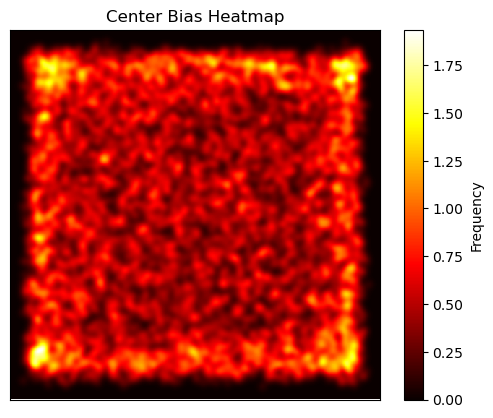

In [6]:
#NOTE: Replace the following path with the path to the folder containing the annotations if you are not using the provided CSV files
# annotations_folder = "annotations_folder_path_here"  

#Storing the paths to the CSV files containing the annotations
annotation_files = ["./Object_Detection_Dataset/CSV/Train/labels.csv", "./Object_Detection_Dataset/CSV/Val/labels.csv", "./Object_Detection_Dataset/CSV/Test/labels.csv"]
#Reading the annotations from the CSV files
centroids, image_sizes = read_csv_annotations(annotation_files, return_sizes=True)
#Checking if any valid annotations were found
if len(centroids) == 0:
    print("No valid annotations found.")
    exit()
#Calculating the center bias
center_bias = calculate_center_bias(centroids, image_sizes)
#Visualising the center bias
visualize_center_bias(center_bias)

## Resetting Files Function

This function takes two input parameters:

- **csvFile** - The location of the filename to retrieve information from.
- **columnIndex** - The column of the file to search through.

The file is first opened and the directory of the images is removed.

In [7]:
#Defining a function to remove the directory name from a CSV file's column
def removeDirectoryFromColumn(csvFile, columnIndex):
    #Reading the CSV file and storing its contents
    with open(csvFile, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)

    #Removing the directory name from each value in the specified column
    for row in rows:
        row[columnIndex] = os.path.basename(row[columnIndex])

    #Writing the modified data back to the CSV file
    with open(csvFile, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)

#Removing the directory name from the first column of the CSV files
removeDirectoryFromColumn("./Object_Detection_Dataset/CSV/Train/labels.csv", 0)
removeDirectoryFromColumn("./Object_Detection_Dataset/CSV/Val/labels.csv", 0)
removeDirectoryFromColumn("./Object_Detection_Dataset/CSV/Test/labels.csv", 0)